# classification_dataset

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import math
import keras
import cv2 as cv
import json
import tensorflow as tf
import shutil

2025-04-14 18:47:04.868943: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 18:47:04.947204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744667224.974551    7941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744667224.984172    7941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 18:47:05.047496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Definitions

In [2]:
CSV_PATH = '../../output/cropped_cells/data/'
CROPS_PATH = '../../output/cropped_cells/media/'
MODEL_PATH = '../../models/model_Encoder_SSIM+MAE0 (1).keras'
IMAGES_PATH = '../../media/data/input_color/'
JSON_PATH = '../../media/corte-27-02-2024.json'
OUTPUT_PATH = '../../media/classification/'


### Functions

In [3]:
def get_coco_bbox(data, id):
  """
  Given a list of objects it returns a list of bounding boxes for the given id.

  Args:
    data: list of objects to search from.
    id: id of the objetct to search.

  Returns:
    A list of bounding boxes.
  """
  bboxes = [cell['bbox'] for cell in data['annotations'] if cell['image_id'] == id]
  classes = [cell['attributes']['Fase'] for cell in data['annotations'] if cell['image_id'] == id]
  return bboxes, classes

def bb_overlap_percentage(box1, box2):

    """
    Calculates the Intersection over Union (IoU) of two bounding boxes using Shapely.

    Args:
        box1: A tuple or list containing (x1, y1, width, height) of the first bounding box.
        box2: A tuple or list containing (x1, y1, width, height) of the second bounding box.

    Returns:
        The IoU value, a float between 0 and 1.
    """

    # Calculate box coordinates
    x1_min, y1_min, width1, height1 = box1
    x1_max = x1_min + width1
    y1_max = y1_min + height1
    x2_min, y2_min, width2, height2 = box2
    x2_max = x2_min + width2
    y2_max = y2_min + height2

    # Create polygons
    poly1 = Polygon([(x1_min, y1_min), (x1_max, y1_min), (x1_max, y1_max), (x1_min, y1_max)])
    poly2 = Polygon([(x2_min, y2_min), (x2_max, y2_min), (x2_max, y2_max), (x2_min, y2_max)])

    # Calculate intersection and union areas
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area

    #print(poly1.area, poly2.area, intersection)

    return intersection / poly1.area if union > 0 else 0.0

def bbox_fully_contained(bbox1, bbox2):
    """
    Checks if bounding box 1 is fully contained within bounding box 2.

    Args:
        bbox1: A tuple (x1, y1, width1, height1) representing the first bounding box.
        bbox2: A tuple (x2, y2, width2, height2) representing the second bounding box.

    Returns:
        True if bbox1 is fully contained within bbox2, False otherwise.
    """

    # Calculate coordinates of bounding boxes
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    bbox1_coords = [(x1, y1), (x1 + w1, y1), (x1 + w1, y1 + h1), (x1, y1 + h1)]
    bbox2_coords = [(x2, y2), (x2 + w2, y2), (x2 + w2, y2 + h2), (x2, y2 + h2)]

    # Create Shapely polygons
    poly1 = Polygon(bbox1_coords)
    poly2 = Polygon(bbox2_coords)

    # Check if bbox1 is fully contained within bbox2
    return poly1.within(poly2)

def bbox_intercept(bbox, bbox_list, threshold=0):
  for idx, bbox_target in enumerate(bbox_list):
    if threshold > 0: # 0.75
      iou = bb_overlap_percentage(bbox, bbox_target)
      if iou >= threshold:
        return True, idx

    else:
      contained = bbox_fully_contained(bbox, bbox_target)
      if contained:
        return True, idx

  return False, -1

def find_image_name(data, id):
  """
  Given a list of objects it searches the file_name from the id.

  Args:
    data: list of objects to search from.
    id: id of the file name to return.

  Returns:
    The file name of the image id.
  """
  for img in data:
      if img['id'] == id:
          base_name, _ = os.path.splitext(img['file_name'])
          return base_name

def process_images_in_batches(string_list, batch_size=10):
  """
  Processes a list of strings in batches of a specified size.

  Args:
    string_list: The list of strings to process.
    batch_size: The size of each batch.

  Yields:
    A batch of strings.
  """
  for i in range(0, len(string_list), batch_size):
    batch_num = i // batch_size + 1  # Calculate batch number (1-indexed)
    yield batch_num, string_list[i:i + batch_size]

def predict_cell(model, image_path, images_batch, color_type):
  """
  Given an image batch it returns the predictions of the batch with the given model.

  Args:
    model: keras model to use.
    image_path: path to the folder where the images are.
    images_batch: list of the image names to include in the batch

  Returns:
    A list of predictions.
  """

  images = []
  for image in images_batch:
      img = cv.imread(os.path.join(image_path,image), color_type)
      img = cv.resize(img, (128, 128))
      img = img / 255.0
      images.append(img)
  
  batch = np.stack(images)
  if color_type == cv.IMREAD_GRAYSCALE:\
    # Add missing channel
    batch = np.expand_dims(batch, axis=-1).astype(np.float32)

  prediction = model.predict(batch, verbose=0)
  prediction = tf.nn.softmax(prediction, axis=-1)
  return prediction

### List of elements to use

In [4]:
csvs = sorted(os.listdir(CSV_PATH)) #Paths to the csv of SAM detections of each image
crops = sorted(os.listdir(CROPS_PATH)) #Paths to the crops made from SAM detection of the full_images
# images = sorted(os.listdir(IMAGES_PATH)) #full_images from where the crops are made
with open(JSON_PATH, 'r') as f: #json with the information of the filename of the images
    data = json.load(f)

model = keras.models.load_model(MODEL_PATH)

I0000 00:00:1744667229.531050    7941 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21372 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


### Dataset generations

In [ ]:
cell_crops = []
cell_bboxes = []

if model.input.shape[-1] == 1:
    color_type = cv.IMREAD_GRAYSCALE
else:
    color_type = cv.IMREAD_COLOR

batch_size=30
empty = []

for idx, batch in process_images_in_batches(crops, batch_size=batch_size): #Read the images in batch_size batches

    batch_prediction = predict_cell(model, image_path=CROPS_PATH, images_batch=batch, color_type=color_type)

    is_cell = 1-np.argmax(batch_prediction, axis=1).astype(bool)

    for idx, crop in enumerate(batch):
        if is_cell[idx]:
            image_name = crop.rsplit('_', 1)[0]
            cell_id = crop.split('_')[1].split('.')[0]

            df = pd.read_csv(os.path.join(CSV_PATH, f"{image_name}.csv"))
            df_bbox = df[df['cell_id'] == int(cell_id)]

            bbox = df_bbox[['x', 'y', 'w', 'h']].values.flatten().tolist()

            cell_crops.append(int(image_name))
            cell_bboxes.append(bbox)

            bboxes_coco, classes_coco =  get_coco_bbox(data, int(image_name))

            intercept, coco_idx = bbox_intercept(bbox, bboxes_coco, 0.75)

            if intercept:
                output_dir = os.path.join(OUTPUT_PATH, classes_coco[coco_idx])
                os.makedirs(output_dir, exist_ok=True)
                shutil.copy(os.path.join(CROPS_PATH, crop), output_dir)
                

In [ ]:
CSV_PATH = '../../output/cropped_cells/data/'
IMAGE_PATH = '../../media/data/input_color/'
CLASSES_PATH = "../../media/classification/"

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

def get_class_images(folder_path, img_number):
    """
    Creates a dictionary where keys are class names (subfolder names) and values are lists of image file names.

    Args:
        folder_path: Path to the main folder containing subfolders as classes.

    Returns:
        A dictionary with class names as keys and lists of image file names as values.
    """
    class_images = {}

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):  # Check if it's a subfolder
            images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img)) and str(img_number) in img]
            class_images[class_name] = images

    return class_images


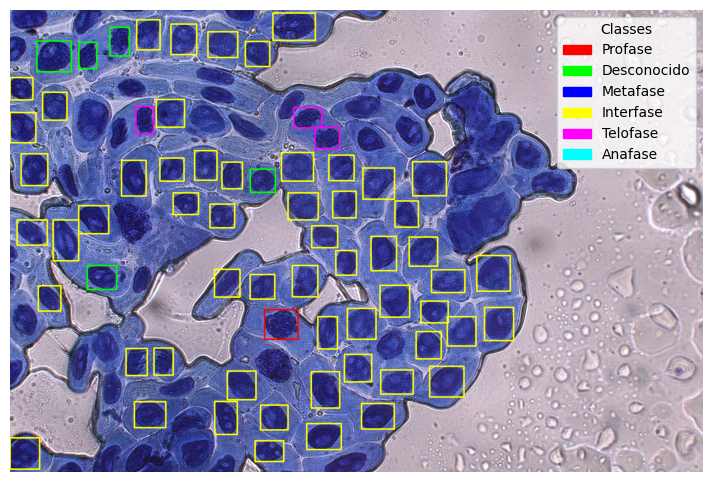

In [5]:
IMAGE_NUMBER = 341
CSV_PATH = '../../output/cropped_cells/data/'
IMAGE_PATH = '../../media/data/input_color/'
CLASSES_PATH = "../../media/classification/"

image = cv.imread(os.path.join(IMAGE_PATH, f"{str(IMAGE_NUMBER)}.png"))
df = pd.read_csv(os.path.join(CSV_PATH, f"{str(IMAGE_NUMBER)}.csv"))

def get_class_images(folder_path, img_number):
    """
    Creates a dictionary where keys are class names (subfolder names) and values are lists of image file names.

    Args:
        folder_path: Path to the main folder containing subfolders as classes.

    Returns:
        A dictionary with class names as keys and lists of image file names as values.
    """
    class_images = {}

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):  # Check if it's a subfolder
            images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img)) and str(img_number) in img]
            class_images[class_name] = images

    return class_images

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

class_images_dict = get_class_images(CLASSES_PATH, IMAGE_NUMBER)
class_bboxes_dict = {key: [] for key in class_images_dict.keys()}
class_colors_dict = {key: colors[i % len(colors)] for i, key in enumerate(class_images_dict.keys())}

for img_class in class_images_dict.keys():
    for img in class_images_dict[img_class]:
        df_bbox = df[df['cell_id'] == int(img.split('_')[1].split('.')[0])]
        bbox = df_bbox[['x', 'y', 'w', 'h']].values.flatten().tolist()
        class_bboxes_dict[img_class].append(bbox)

for bbox_class in class_bboxes_dict.keys():
    for bbox in class_bboxes_dict[bbox_class]:
        x, y, w, h = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
        cv.rectangle(image, (x1, y1), (x2, y2), class_colors_dict[bbox_class], 5)

import matplotlib.patches as mpatches

# Create a list of legend patches for each class and its corresponding color
legend_patches = [mpatches.Patch(color=[c/255 for c in class_colors_dict[cls]], label=cls) for cls in class_colors_dict.keys()]

# Plot the image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis('off')

# Add the legend to the plot
plt.legend(handles=legend_patches, loc='upper right', fontsize=10, title="Classes")
plt.show()
